In [6]:
# Merging weather and tickets csv files
import pandas as pd

lax_df = pd.read_csv("LAX_BEI_cleaned.csv")
paris_df = pd.read_csv("Paris_cleaned.csv")
riyadh_df = pd.read_csv("Riyadh_cleaned.csv")

lax_df['Origin'] = 'LA'
paris_df['Origin'] = 'Paris'
riyadh_df['Origin'] = 'Riyadh'

tickets_df = pd.concat([lax_df, paris_df, riyadh_df], ignore_index=True)

weather_df = pd.read_csv("weather_temp.csv")

weather_df.rename(columns={'Location': 'Origin', 'Date': 'Departure'}, inplace=True)

tickets_df['Departure'] = pd.to_datetime(tickets_df['Departure'])
weather_df['Departure'] = pd.to_datetime(weather_df['Departure'])

merged_df = pd.merge(tickets_df, weather_df, on=['Origin', 'Departure'], how='left')

merged_df.to_csv("merged_tickets_with_weather.csv", index=False)

In [7]:
# cleaning and encoding the merged csv file

df = pd.read_csv("merged_tickets_with_weather.csv")

df['Origin'] = df['Origin'].replace({
    'LA': 'LAX',
    'Paris': 'PAR',
    'Riyadh': 'RUH'
})

df['Route'] = df['Origin'] + "-BEI-" + df['Origin']

df['Departure'] = pd.to_datetime(df['Departure'])
df['Return'] = pd.to_datetime(df['Return'])

categorical_cols = ['Airline', 'Flight Type', 'Price Type', 'Season', 'Origin', 'Rain']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

df_encoded.to_csv("tickets_encoded_for_ml.csv", index=False)

print(df_encoded.head())

   Departure     Return Duration  Transit   Price  Competitor Price  \
0 2025-04-02 2025-04-09  17h 30m        1  1393.0           1435.84   
1 2025-04-02 2025-04-09  20h 25m        1   992.0           1034.84   
2 2025-04-02 2025-04-09  35h 05m        1  1513.0           1555.84   
3 2025-04-02 2025-04-09  36h 20m        1  1151.0           1193.84   
4 2025-04-02 2025-04-09  17h 30m        1  1114.0           1156.84   

   Duration in Minutes  Price per Hour  Average Temp (°C)  Precipitation (mm)  \
0                 1050           79.60               13.6                 0.2   
1                 1225           48.59               13.6                 0.2   
2                 2105           43.13               13.6                 0.2   
3                 2180           31.68               13.6                 0.2   
4                 1050           63.66               13.6                 0.2   

   ... Flight Type_Medium  Flight Type_Short  Price Type_Cheap  \
0  ...              

In [ ]:
df_xai = pd.read_csv("merged_tickets_with_weather.csv")
columns_to_exclude = ['Price Type','Departure', 'Return','Price','Duration','Competitor Price','Price per Hour']
X_xai = df_xai.drop(columns=columns_to_exclude)
for col in X_xai.select_dtypes(include='object').columns:
    X_xai[col] = le.fit_transform(X_xai[col])

y_xai = df_xai['Price']
X_train, X_test, y_train, y_test = train_test_split(X_xai, y_xai, test_size=0.2, random_state=42)

In [ ]:
import xgboost as xgb
import shap
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)
shap_importance = np.abs(shap_values.values).mean(axis=0)

N = 10
important_features = np.argsort(shap_importance)[::-1]
selected_features = important_features[:N]

X_train_selected = X_train.iloc[:, selected_features]
X_test_selected = X_test.iloc[:, selected_features]
shap_values_selected = shap_values.values[:, selected_features]

shap.summary_plot(shap_values_selected, X_train_selected)

In [ ]:
shap.plots.waterfall(shap_values[0])

In [8]:
# train a random forest model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

df = pd.read_csv("tickets_encoded_for_ml.csv")

columns_to_exclude = ['Departure', 'Return', 'Duration', 'Price', 'Route']
X = df.drop(columns=columns_to_exclude)
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): $9.23
Mean Squared Error (MSE): 514.48
Root Mean Squared Error (RMSE): 22.68
R² Score: 0.9962


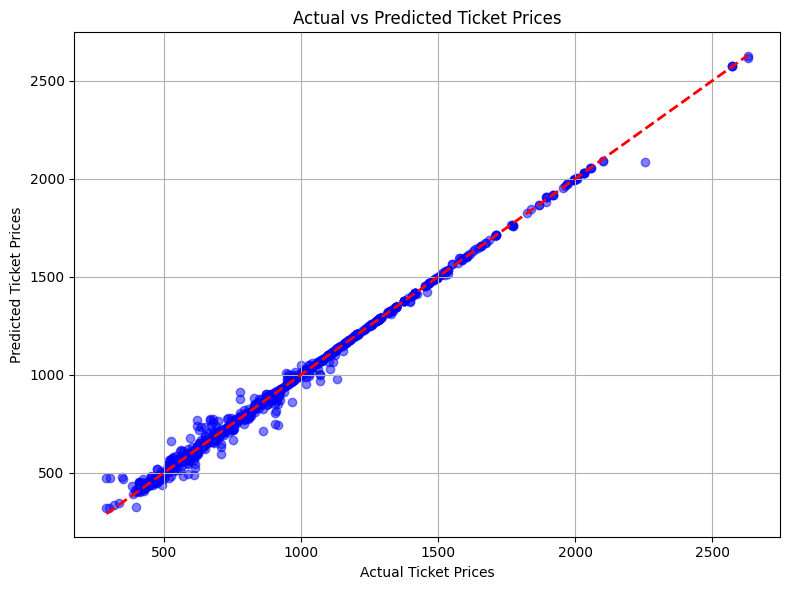

In [9]:
# plot actual vs predicted prices
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel("Actual Ticket Prices")
plt.ylabel("Predicted Ticket Prices")
plt.title("Actual vs Predicted Ticket Prices")
plt.grid(True)
plt.tight_layout()
plt.show()